<h1>Class 3</h1>
<br>
- 나이분류 (20~59), (60~79), 80 이상
- 동양인만

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.layers import *
from keras.models import Model
import keras

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

In [2]:
data_dir = '../UTKFace'

In [3]:
from PIL import Image
image = Image.open(data_dir+'/1_0_0_20161219140623097.jpg.chip.jpg')
image.show()

In [4]:
files = []
ages = []

file_names = os.listdir(data_dir)
for file_name in file_names:
    test = file_name.split('_')
    
    if len(test) == 4:
        age, gender, race, _ = file_name.split('_')
        
        if (int(age) >= 20 and int(age) < 100 and int(race) == 3 ):
            files.append(file_name)
            ages.append(int(age))
            
# 데이터 프레임 생성
df = pd.DataFrame({'file_name': files, 'age': ages})
df

,file_name,age
0,40_1_3_20170116191729090.jpg.chip.jpg,40
1,41_0_3_20170119143544485.jpg.chip.jpg,41
2,26_0_3_20170119180343596.jpg.chip.jpg,26
3,54_1_3_20170105001159796.jpg.chip.jpg,54
4,37_0_3_20170119202410749.jpg.chip.jpg,37
...,...,...
3330,21_1_3_20170104222046054.jpg.chip.jpg,21
3331,29_0_3_20170119183457486.jpg.chip.jpg,29
3332,65_0_3_20170119203936910.jpg.chip.jpg,65
3333,65_1_3_20170109143047483.jpg.chip.jpg,65


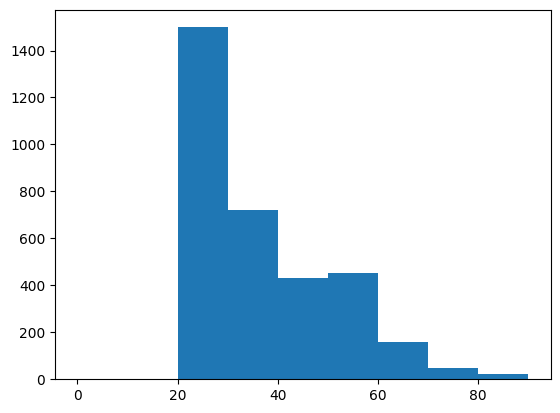

In [5]:
plt.hist(df['age'], bins=range(0, 100, 10))
plt.show()

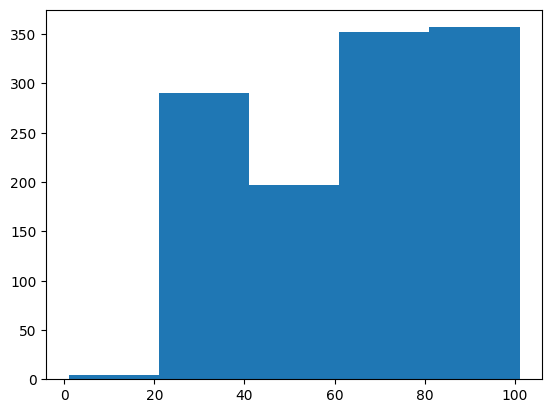

In [6]:
# 데이터셋을 읽어들입니다.
data = df

# 각 나이별로 데이터를 분할합니다.
age_groups = [(20, 59), (60, 79), (80, 100)]
age_data = [data[(data['age'] >= group[0]) & (data['age'] <= group[1])] for group in age_groups]

# 각 나이 그룹에서 샘플링할 개수를 정합니다.
target_size = 400
sample_sizes = [target_size] * len(age_data)


# 언더샘플링을 수행합니다.
sampled_data = []
for group, size in zip(age_data, sample_sizes):
    if len(group) >= size:
        sampled_group = resample(group, replace=False, n_samples=size, random_state=42)
    else:
        sampled_group = group
    sampled_data.append(sampled_group)
new_data = pd.concat(sampled_data)

# 오버샘플링을 수행합니다.
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X, y = new_data.iloc[:, :-1].values, new_data['age'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
new_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['age'])], axis=1)

# 각 나이 그룹에서 3000개씩 샘플링합니다.
sampled_data = []
for group, size in zip(age_data, sample_sizes):
    if len(group) > size:
        sampled_group = resample(group, replace=False, n_samples=size, random_state=42)
    else:
        sampled_group = group.sample(size, replace=True, random_state=42)
    sampled_data.append(sampled_group)
new_data = pd.concat(sampled_data)


# 나이 분포를 시각화합니다.
plt.hist(new_data['age'], bins=range(1, 120, 20))
plt.show()

In [7]:
new_data

,file_name,age
1786,27_0_3_20170104200540418.jpg.chip.jpg,27
2354,27_1_3_20170104232645690.jpg.chip.jpg,27
328,34_0_3_20170119200611509.jpg.chip.jpg,34
798,38_1_3_20170109140706612.jpg.chip.jpg,38
1180,36_1_3_20170119202143325.jpg.chip.jpg,36
...,...,...
2222,89_0_3_20170105180114246.jpg.chip.jpg,89
2060,80_0_3_20170117174541085.jpg.chip.jpg,80
1748,88_1_3_20170110182157752.jpg.chip.jpg,88
2422,85_1_3_20170110183946188.jpg.chip.jpg,85


In [8]:
dataset = new_data.copy()

import pandas as pd
import numpy as np

agelist = [
    (dataset['age'] < 60),
    (dataset['age'] >= 60) & (dataset['age'] < 80),
    (dataset['age'] >= 80)
]

'''
0: 2~50대
1: 6~70대
2: 80대 이상
'''
ageRangeList = [0, 1, 2]

dataset['ageRange'] = np.select(agelist, ageRangeList, default='')

dataset['path'] = dataset['file_name'].apply(lambda x: f"{data_dir}/{x}")

dataset = dataset.drop(['file_name', 'age'], axis=1)

In [9]:
dataset.to_pickle("./class3_dataset.pkl")

In [21]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

batch_size = 32
epochs = 50
input_shape = (200, 200, 3)

# 이미지 증강 세팅
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)



# 학습 데이터셋 생성
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='path',
    y_col='ageRange',
    target_size=input_shape[:2],
    batch_size = batch_size,
    class_mode='categorical'
)

# 검증 데이터셋 생성
test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='path',
    y_col='ageRange',
    target_size=input_shape[:2],
    batch_size = batch_size,
    class_mode='categorical'
)

Found 960 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.


In [22]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':input_shape,
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    layer1 = tf.keras.layers.Flatten()(pretrained_model.output)
    layer2 = tf.keras.layers.Dense(1024, activation="relu")(layer1)
    drop1 = tf.keras.layers.Dropout(0.2)(layer2)
    output_layer = tf.keras.layers.Dense(3, activation='softmax')(drop1)


    model = tf.keras.Model(inputs=inputs, outputs=output_layer)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [23]:
model = get_model(tf.keras.applications.ResNet152V2)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델을 학습합니다.
checkpoint_path = "./class3/best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

In [25]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./class3_logs')

In [26]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=200,
    batch_size=batch_size,
    callbacks=[checkpoint, tensorboard_callback]
)

/home/uit-na/anaconda3/envs/hello/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
30/30 [==============================] - ETA: 0s - loss: 1.4045 - accuracy: 0.5760
Epoch 00001: val_accuracy improved from -inf to 0.80417, saving model to ./class3/best_model.h5
30/30 [==============================] - 13s 291ms/step - loss: 1.4045 - accuracy: 0.5760 - val_loss: 0.5197 - val_accuracy: 0.8042
Epoch 2/200
30/30 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.7625
Epoch 00002: val_accuracy improved from 0.80417 to 0.86250, saving model to ./class3/best_model.h5
30/30 [==============================] - 7s 235ms/step - loss: 0.5715 - accuracy: 0.7625 - val_loss: 0.4195 - val_accuracy: 0.8625
Epoch 3/200
30/30 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.8188
Epoch 00003: val_accuracy improved from 0.86250 to 0.87083, saving model to ./class3/best_model.h5
30/30 [==============================] - 7s 233ms/step - loss: 0.4535 - accuracy: 0.8188 - val_loss: 0.3910 - val_accuracy: 0.8708
Epoch 4/200
30/30 [========

Epoch 29/200
30/30 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9115
Epoch 00029: val_accuracy did not improve from 0.92500
30/30 [==============================] - 6s 206ms/step - loss: 0.2086 - accuracy: 0.9115 - val_loss: 0.2586 - val_accuracy: 0.9167
Epoch 30/200
30/30 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9000
Epoch 00030: val_accuracy did not improve from 0.92500
30/30 [==============================] - 6s 212ms/step - loss: 0.2253 - accuracy: 0.9000 - val_loss: 0.2422 - val_accuracy: 0.9042
Epoch 31/200
30/30 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8833
Epoch 00031: val_accuracy did not improve from 0.92500
30/30 [==============================] - 6s 206ms/step - loss: 0.2788 - accuracy: 0.8833 - val_loss: 0.2910 - val_accuracy: 0.8958
Epoch 32/200
30/30 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.9031
Epoch 00032: val_accuracy did not improve from 0.92500
30/

Epoch 58/200
30/30 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9281
Epoch 00058: val_accuracy did not improve from 0.94167
30/30 [==============================] - 6s 204ms/step - loss: 0.1726 - accuracy: 0.9281 - val_loss: 0.1760 - val_accuracy: 0.9333
Epoch 59/200
30/30 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9510
Epoch 00059: val_accuracy did not improve from 0.94167
30/30 [==============================] - 6s 205ms/step - loss: 0.1345 - accuracy: 0.9510 - val_loss: 0.1751 - val_accuracy: 0.9417
Epoch 60/200
30/30 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9208
Epoch 00060: val_accuracy did not improve from 0.94167
30/30 [==============================] - 6s 204ms/step - loss: 0.1874 - accuracy: 0.9208 - val_loss: 0.2245 - val_accuracy: 0.9125
Epoch 61/200
30/30 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9292
Epoch 00061: val_accuracy did not improve from 0.94167
30/

30/30 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9479
Epoch 00087: val_accuracy did not improve from 0.94167
30/30 [==============================] - 6s 214ms/step - loss: 0.1410 - accuracy: 0.9479 - val_loss: 0.2215 - val_accuracy: 0.9333
Epoch 88/200
30/30 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9333
Epoch 00088: val_accuracy did not improve from 0.94167
30/30 [==============================] - 6s 212ms/step - loss: 0.1593 - accuracy: 0.9333 - val_loss: 0.1965 - val_accuracy: 0.9333
Epoch 89/200
30/30 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9500
Epoch 00089: val_accuracy did not improve from 0.94167
30/30 [==============================] - 7s 216ms/step - loss: 0.1558 - accuracy: 0.9500 - val_loss: 0.2186 - val_accuracy: 0.9333
Epoch 90/200
30/30 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9469
Epoch 00090: val_accuracy did not improve from 0.94167
30/30 [=========

Epoch 116/200
30/30 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9490
Epoch 00116: val_accuracy did not improve from 0.95417
30/30 [==============================] - 6s 209ms/step - loss: 0.1456 - accuracy: 0.9490 - val_loss: 0.2453 - val_accuracy: 0.9333
Epoch 117/200
30/30 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9458
Epoch 00117: val_accuracy did not improve from 0.95417
30/30 [==============================] - 6s 208ms/step - loss: 0.1363 - accuracy: 0.9458 - val_loss: 0.2864 - val_accuracy: 0.9042
Epoch 118/200
30/30 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9490
Epoch 00118: val_accuracy did not improve from 0.95417
30/30 [==============================] - 6s 210ms/step - loss: 0.1222 - accuracy: 0.9490 - val_loss: 0.2121 - val_accuracy: 0.9458
Epoch 119/200
30/30 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9521
Epoch 00119: val_accuracy did not improve from 0.95417

Epoch 145/200
30/30 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9615
Epoch 00145: val_accuracy did not improve from 0.95833
30/30 [==============================] - 6s 209ms/step - loss: 0.0989 - accuracy: 0.9615 - val_loss: 0.2331 - val_accuracy: 0.9375
Epoch 146/200
30/30 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9573
Epoch 00146: val_accuracy did not improve from 0.95833
30/30 [==============================] - 6s 208ms/step - loss: 0.1068 - accuracy: 0.9573 - val_loss: 0.2294 - val_accuracy: 0.9375
Epoch 147/200
30/30 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9625
Epoch 00147: val_accuracy did not improve from 0.95833
30/30 [==============================] - 6s 210ms/step - loss: 0.1009 - accuracy: 0.9625 - val_loss: 0.1883 - val_accuracy: 0.9583
Epoch 148/200
30/30 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9635
Epoch 00148: val_accuracy did not improve from 0.95833

Epoch 174/200
30/30 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9635
Epoch 00174: val_accuracy did not improve from 0.96667
30/30 [==============================] - 6s 212ms/step - loss: 0.0859 - accuracy: 0.9635 - val_loss: 0.1948 - val_accuracy: 0.9625
Epoch 175/200
30/30 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9656
Epoch 00175: val_accuracy did not improve from 0.96667
30/30 [==============================] - 6s 210ms/step - loss: 0.0942 - accuracy: 0.9656 - val_loss: 0.1864 - val_accuracy: 0.9500
Epoch 176/200
30/30 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9625
Epoch 00176: val_accuracy did not improve from 0.96667
30/30 [==============================] - 6s 210ms/step - loss: 0.0918 - accuracy: 0.9625 - val_loss: 0.2012 - val_accuracy: 0.9625
Epoch 177/200
30/30 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9594
Epoch 00177: val_accuracy did not improve from 0.96667

In [ ]:
tensorboard --logdir=./class3_logs